In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
#z_train: flattened version of x_train
z_train = [list(np.reshape(x_train_, (np.product(x_train_.shape)))) + [y_train_] for x_train_,y_train_ in zip(x_train, y_train)]

In [4]:
#z_test: flattened version of x_test
z_test = [list(np.reshape(x_test_, (np.product(x_test_.shape)))) + [y_test_] for x_test_,y_test_ in zip(x_test, y_test)]

In [5]:
%matplotlib inline

4


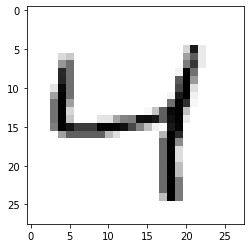

In [6]:
image_index = 2
print(y_train[image_index])
plt.imshow(x_train[image_index], cmap='Greys')
plt.show()

In [7]:
#Dooheon: We may change the type of questions. In that case, func:'finde_best_split' should be changed as well.

class Question:
    """A Question is used to partition a dataset.
    This class just records a 'pixcel index' (index in [0,28^2-1]) and 'threshold'. 
    The 'test' method is used to compare the threshold of the pixel's value in the sample 
    to the threshold stored in the question. 
    """

    def __init__(self, index_pixcel, threshold):
        self.index_pixcel = index_pixcel
        self.threshold = threshold

    def test(self, sample):
        # sample: list-like, size 28^2 or 28^2+1 (when label is appended)
        val = sample[self.index_pixcel]
        return val >= self.threshold
        
    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        return "Is %s-th pixcel >= %s?" % (self.index_pixcel, str(self.threshold))

In [8]:
def partition(samples, question):
    """
    Partitions samples.
    For each sample in the samples, check if it passes the question. If
    so, add it to 'true samples', otherwise, add it to 'false samples'.
    """
    true_samples, false_samples = [], []
    for sample in samples:
        if question.test(sample):
            true_samples.append(sample)
        else:
            false_samples.append(sample)
    return true_samples, false_samples

In [9]:
def distribution(samples):
    """returns the distribution (counting) of the number of each label in the samples."""
    distribution = {}  # a dictionary of label -> count.
    for sample in samples:
        # in our dataset format, the label is always the last column
        label = sample[-1]
        distribution.setdefault(str(label), 0)
        distribution[str(label)] += 1
    return distribution

In [10]:
def gini_index(samples):
    dist = distribution(samples)
    gini = -1.0
    for lbl in dist:
        prob_of_lbl = dist[lbl] / float(len(samples))
        gini -= prob_of_lbl**2
    return gini

In [11]:
def info_gain(left, right, current_uncertainty):
    """Information Gain.
    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    information_gain = current_uncertainty - p * gini_index(left) - (1 - p) * gini_index(right)
    return information_gain

In [12]:
def find_best_question(samples):
    """
    Find the best question to ask among a selected set of questions
    and calculate the information gain.
    """
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep track of the feature / value that produced it
    current_uncertainty = gini_index(samples)
    n_features = len(samples[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature
        values = sorted(set([row[col] for row in samples]))
        values_used = []
        prev_val = -1
        for val in values:  # for each value
            if val < prev_val + 5:
                continue # The resolution of the question is 5
            prev_val = val
            question = Question(col, val)

            # try questionting the dataset
            true_samples, false_samples = partition(samples, question)

            # Skip this question if it doesn't divide the
            # dataset.
            if len(true_samples) == 0 or len(false_samples) == 0:
                continue

            # Calculate the information gain from this question
            gain = info_gain(true_samples, false_samples, current_uncertainty)

            # You actually can use '>' instead of '>=' here
            # but I wanted the tree to look a certain way for our
            # toy dataset.
            if gain >= best_gain:
                best_gain, best_question = gain, question
        
    return best_gain, best_question

In [13]:
class Leaf:
    """A Leaf node classifies data.
    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the samples from the training data that reach this leaf.
    """
    def __init__(self, samples):
        self.predictions = distribution(samples)
    def __repr__(self):
        output = ''
        for lbl in self.predictions:
            output += '%s: %s\n'%(lbl, self.predictions[lbl])
        return output        

In [14]:
class Decision_Node:
    """A Decision Node asks a question.
    This holds a reference to the question, and to the two child nodes.
    """
    def __init__(self,
                 question,
                 true_node,
                 false_node):
        self.question = question
        self.true_node = true_node
        self.false_node = false_node

In [15]:
def build_tree(samples_train):
    """
    Builds the tree. Returns the top node, which can be a class:'Leaf' or class:'Decision_Node'
    It is the key in recursive definition to believe that the function already exists. 
    """
    gain, question = find_best_question(samples_train)
    if gain == 0:
        return Leaf(samples_train)
    true_samples_train, false_samples_train = partition(samples_train, question)
    true_branch = build_tree(true_samples_train)
    false_branch = build_tree(false_samples_train)
    return Decision_Node(question, true_branch, false_branch)

In [16]:
def print_tree(node, spacing=""):
    "Again, recursive definition"
    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print(spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true node
    print (spacing + '--> True:')
    print_tree(node.true_node, spacing + "  ")

    # Call this function recursively on the false node
    print (spacing + '--> False:')
    print_tree(node.false_node, spacing + "  ")

In [32]:
def classify(sample, tree):
    """Recursive definition"""
    if isinstance(tree, Leaf):
        #print(tree)
        return tree.predictions
    #print(tree.question)
    if tree.question.test(sample):
        #print('True')
        return classify(sample, tree.true_node)
    else:
        #print('False')
        return classify(sample, tree.false_node)

In [28]:
import pickle
#Load the tree calibrated and saved before
with open('./my_tree.pkl', 'rb') as f:
    my_tree = pickle.load(f)

In [18]:
%%time
######This took > 6 hours to me
#my_tree = build_tree(z_train)

#####Save calibrated tree as a pickle
#with open('./my_tree.pkl', 'wb') as f:
#    pickle.dump(my_tree, f)

CPU times: user 6h 57min 22s, sys: 49.5 s, total: 6h 58min 11s
Wall time: 6h 58min 21s


In [34]:
matches = []
for index in range(len(z_test)):
    prediction = classify(z_test[index], my_tree)
    if str(z_test[index][-1]) not in prediction:
        result = False
    else:
        result = True
        for lbl in prediction:
            result = result and prediction[str(z_test[index][-1])] >= prediction[lbl]
    matches.append(result)    

correct = matches.count(True)
incorrect = matches.count(False)

In [36]:
print('correct', correct)
print('incorrect', incorrect)

correct 8765
incorrect 1235
